In [1]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy
import astropy.coordinates as coord
import astropy.units as u

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

### Pandas
import pandas as pd

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable

# # ### Yumi's RA/DEC ---> Magellanic Stream Coorindates
# import MagellanicStream as ms

### Functions used in this code
import age_functions as afunc
import extinction as extinct
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757} # mircons

### Stuff Writtten by A Really Cool Professor
from dlnpyutils import utils as dln

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

In [2]:
# def add_noise(quant,quant_err,distribution='normal'):
#     '''
#     Add noise to data and return new values
    
#     Parameters:
#     ----------
#         quant: 1d array-like data to add noise to
#         quant_err: 1d array-like object of errors for quant
#         distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
#     return: 
#     ------
#         1d array-like object of data with added noise
    
#     '''
#     if distribution == 'normal':
#         return np.random.normal(quant,quant_err)
#     if distribution == 'poisson':
#         return quant + np.random.poisson(quant_err)
#     if distribution == 'uniform':
#         return np.random.uniform(-quant_err+quant,quant+quant_err)

# Import GCs

In [3]:
gcs = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r13-l33-58932beta_apa_dist_galvel_gc.fits',1)
cln = np.where((gcs['FE_H']>-9999.0)&(gcs['AK_TARG']>-9999.0)&(gcs['LOGG']>0.0)&(gcs['M_H_ERR']>-90.0)&
                (gcs['C_FE']>-9999.0)&(gcs['N_FE']>-9999.0))
gcs = Table(gcs[cln])


harris_dist = [4.5,4.4,6.4,4.8,7.1,10.4,8.8,11.5,3.2,10.2,2.2,7.5,17.9,26.5,5.4,10.3,4.0,12.9,8.3,12.1,9.6,8.9,
               4.9,8.6,19.3,17.4,16.0,8.9,30.5,9.5,5.9,10.4,9.9,2.3,11.6,7.7,3.0,10.9,8.1,8.7,4.0,7.4,23.2,5.8,
               8.2,7.1,10.9,5.2]
harris_ebv = [0.04,0.28,0.33,0.19,0.02,0.10,0.38,0.10,0.34,0.01,0.35,0.03,0.02,0.15,0.08,0.05,0.25,0.01,0.02,0.02,
              0.22,0.03,0.24,0.05,0.02,0.01,0.00,0.36,0.01,0.36,0.54,0.54,0.37,0.18,0.47,0.48,0.76,0.53,0.40,0.05,
              0.04,0.77,0.03,1.46,1.24,1.76,1.17,0.12]

gcs['harris_dist'] = np.zeros(len(gcs))
gcs['harris_ebv'] = -9999.0*np.ones(len(gcs))

for i in range(len(np.unique(gcs['CLUSTER']))):
    clus = np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])
    gcs['harris_dist'][clus] = harris_dist[i]
    gcs['harris_ebv'][clus] = harris_ebv[i]

In [4]:
### Find Cluster with more than one star

idx = []
for i in range(len(np.unique(gcs['CLUSTER']))):
    idx.append(np.squeeze(np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])))

for i in range(len(idx)):
    try:
        len(idx[i])
    except:
        print('bad: ',i)

bad:  24
bad:  27
bad:  37


In [5]:
# print(idx)

In [6]:
### Find Clusters with more than 10 stars

good_names = []
for i in np.asarray(idx)[np.delete(np.asarray(list(range(len(idx)))),[24,27,37])]:
    if len(i)>10:
        good_names.append(gcs['CLUSTER'][i][0])

print(good_names)

['47Tuc', 'M10', 'M107', 'M12', 'M13', 'M19', 'M2', 'M22', 'M3', 'M4', 'M5', 'M53', 'M54', 'M55', 'M71', 'M79', 'NGC1851', 'NGC2808', 'NGC288', 'NGC3201', 'NGC362', 'NGC6388', 'NGC6397', 'NGC6752', 'omegaCen']


In [7]:
good_clus = np.where((gcs['CLUSTER']=='47Tuc')|(gcs['CLUSTER']=='M10')|(gcs['CLUSTER']=='M107')|
                     (gcs['CLUSTER']=='M12')|(gcs['CLUSTER']=='M13')|(gcs['CLUSTER']=='M19')|
                     (gcs['CLUSTER']=='M2')|(gcs['CLUSTER']=='M22')|(gcs['CLUSTER']=='M3')|
                     (gcs['CLUSTER']=='M4')|(gcs['CLUSTER']=='M5')|(gcs['CLUSTER']=='M53')|
                     (gcs['CLUSTER']=='M54')|(gcs['CLUSTER']=='M55')|(gcs['CLUSTER']=='M71')|
                     (gcs['CLUSTER']=='M79')|(gcs['CLUSTER']=='NGC1851')|(gcs['CLUSTER']=='NGC2808')|
                     (gcs['CLUSTER']=='NGC288')|(gcs['CLUSTER']=='NGC3201')|(gcs['CLUSTER']=='NGC362')|
                     (gcs['CLUSTER']=='NGGC6388')|(gcs['CLUSTER']=='NGC6397')|(gcs['CLUSTER']=='NGC6752')|
                     (gcs['CLUSTER']=='omegaCen'))

gcs = gcs[good_clus]

# Import OCs

In [8]:
### Open Clusters
allStar = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r13-l33-58932beta.fits.gz',1)
ocs = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/occam_member-DR16.fits',1)
ocs = ocs[np.where((ocs['PM_PROB']>0.01)&(ocs['RV_PROB']>0.01)&(ocs['FEH_PROB']>0.01))]

_, ocs_ind, all_ind = np.intersect1d(ocs['APOGEE_ID'],allStar['APOGEE_ID'],return_indices=True)
ocs_allStar = allStar[all_ind]
ocs = ocs[ocs_ind]

cln = np.where((ocs_allStar['FE_H']>-90.0)&(ocs_allStar['AK_TARG']>-90.0)&(ocs_allStar['LOGG']>0.0)&
               (ocs_allStar['M_H_ERR']>-90.0)&(ocs_allStar['C_FE']>-90.0)&(ocs_allStar['N_FE']>-90.0))
ocs_allStar = ocs_allStar[cln]
ocs = ocs[cln]

In [9]:
np.unique(ocs['CLUSTER'])

chararray(['ASCC 116', 'ASCC 16', 'ASCC 18', 'ASCC 19', 'ASCC 20',
           'ASCC 21', 'Basel 11b', 'Berkeley 17', 'Berkeley 19',
           'Berkeley 20', 'Berkeley 29', 'Berkeley 31', 'Berkeley 33',
           'Berkeley 43', 'Berkeley 44', 'Berkeley 53', 'Berkeley 66',
           'Berkeley 71', 'Berkeley 79', 'Berkeley 91', 'Berkeley 98',
           'Briceno 1', 'Chupina 1', 'Chupina 3', 'Chupina 4',
           'Chupina 5', 'Collinder 220', 'Collinder 69', 'Collinder 70',
           'Collinder 92', 'Collinder 95', 'Czernik 18', 'Czernik 20',
           'Czernik 21', 'Czernik 23', 'Czernik 30', 'Czernik 7',
           'Dol Dzim 4', 'FSR 0304', 'FSR 0394', 'FSR 0494', 'FSR 0496',
           'FSR 0542', 'FSR 0546', 'FSR 0656', 'FSR 0667', 'FSR 0687',
           'FSR 0716', 'FSR 0823', 'FSR 0940', 'FSR 0942', 'FSR 1113',
           'Haffner 4', 'IC 1369', 'IC 166', 'IC 348', 'King 12',
           'King 2', 'King 5', 'King 7', 'Koposov 62', 'L 1641S',
           'Melotte 20', 'Melotte 2

In [10]:
idx = []
for i in range(len(np.unique(ocs['CLUSTER']))):
    idx.append(np.squeeze(np.where(ocs['CLUSTER']==np.unique(ocs['CLUSTER'])[i])))

bad_idx = []
for i in range(len(idx)):
    try:
        len(idx[i])
    except:
#         print('bad: ',i)
        bad_idx.append(i)

In [11]:
print(bad_idx)

[0, 2, 6, 8, 9, 11, 13, 14, 18, 19, 24, 25, 26, 29, 30, 31, 34, 36, 37, 38, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 55, 56, 57, 60, 67, 70, 77, 80, 84, 85, 89, 90, 92, 94, 101, 104, 106, 107, 108, 109, 111, 112, 114, 115]


In [12]:
good_names = []
for i in np.asarray(idx)[np.delete(np.asarray(list(range(len(idx)))),bad_idx)]:
    if len(i)>3:
        good_names.append(ocs['CLUSTER'][i][0])

print(np.unique(good_names))

['ASCC 16' 'ASCC 19' 'ASCC 20' 'ASCC 21' 'Berkeley 17' 'Berkeley 33'
 'Berkeley 53' 'Berkeley 66' 'Berkeley 71' 'Berkeley 98' 'Chupina 3'
 'Collinder 69' 'Collinder 70' 'Czernik 20' 'IC 166' 'King 5' 'King 7'
 'L 1641S' 'Melotte 20' 'Melotte 22' 'Melotte 71' 'NGC 1245' 'NGC 1798'
 'NGC 188' 'NGC 2158' 'NGC 2204' 'NGC 2243' 'NGC 2264' 'NGC 2324'
 'NGC 2420' 'NGC 2682' 'NGC 4337' 'NGC 6705' 'NGC 6791' 'NGC 6811'
 'NGC 6819' 'NGC 7789' 'Ruprecht 147' 'Sigma Orionis' 'Trumpler 5']


In [13]:
# ocs.columns

In [14]:
### Find Cluster with more than one star

# idx = []
# for i in range(len(np.unique(ocs['CLUSTER']))):
#     idx.append(np.where(ocs['CLUSTER']==np.unique(ocs['CLUSTER'])[i]))

    
# bad_idx = []
# for i in range(len(idx)):
#     try:
#         len(np.squeeze(idx[i]))
#     except:
# #         print('bad: ',i)
#         bad_idx.append(i)
        
# good_names = []
# for i in np.asarray(idx)[np.delete(np.asarray(list(range(len(idx)))),bad_idx)]:
#     if len(i)>5:
#         good_names.append(ocs['CLUSTER'][i][0])
    
# np.unique(good_names)



In [15]:
good_clus = np.where((ocs['CLUSTER']=='ASCC 16')|(ocs['CLUSTER']=='ASCC 19')|(ocs['CLUSTER']=='ASCC 20')|
                     (ocs['CLUSTER']=='ASCC 21')|(ocs['CLUSTER']=='Berkeley 17')|(ocs['CLUSTER']=='Berkeley 33')|
                     (ocs['CLUSTER']=='Berkeley 53')|(ocs['CLUSTER']=='Berkeley 66')|
                     (ocs['CLUSTER']=='Berkeley 71')|(ocs['CLUSTER']=='Berkeley 98')|
                     (ocs['CLUSTER']=='Chupina 3')|(ocs['CLUSTER']=='Collinder 69')|
                     (ocs['CLUSTER']=='Berkeley 70')|(ocs['CLUSTER']=='Czernik 20')|(ocs['CLUSTER']=='IC 166')|
                     (ocs['CLUSTER']=='King 5')|(ocs['CLUSTER']=='King 7')|(ocs['CLUSTER']=='L 1641S')|
                     (ocs['CLUSTER']=='Melotte 20')|(ocs['CLUSTER']=='Melotte 22')|
                     (ocs['CLUSTER']=='Melotte 71')|(ocs['CLUSTER']=='NGC 1798')|(ocs['CLUSTER']=='NGC 188')|
                     (ocs['CLUSTER']=='NGC 2158')|(ocs['CLUSTER']=='NGC 2204')|(ocs['CLUSTER']=='NGC 2243')|
                     (ocs['CLUSTER']=='NGC 2264')|(ocs['CLUSTER']=='NGC 2324')|(ocs['CLUSTER']=='NGC 2420')|
                     (ocs['CLUSTER']=='NGC 2682')|(ocs['CLUSTER']=='NGC 4337')|(ocs['CLUSTER']=='NGC 6705')|
                     (ocs['CLUSTER']=='NGC 6791')|(ocs['CLUSTER']=='NGC 6811')|(ocs['CLUSTER']=='NGC 6819')|
                     (ocs['CLUSTER']=='NGC 7789')|(ocs['CLUSTER']=='Ruprecht 147')|
                     (ocs['CLUSTER']=='Sigma Orionis')|(ocs['CLUSTER']=='Trumpler 5'))
ocs = ocs[good_clus]
ocs_allStar = ocs_allStar[good_clus]

In [16]:
# good_clus = np.where((ocs['CLUSTER']=='ASCC 16')|(ocs['CLUSTER']=='ASCC 19')|(ocs['CLUSTER']=='Berkley 17')|
#                      (ocs['CLUSTER']=='Berkley 71')|(ocs['CLUSTER']=='Collinder 69')|(ocs['CLUSTER']=='IC 166')|
#                      (ocs['CLUSTER']=='Melotte 20')|(ocs['CLUSTER']=='Melotte 22')|(ocs['CLUSTER']=='NGC 1245')|
#                      (ocs['CLUSTER']=='NGC 1798')|(ocs['CLUSTER']=='NGC 188')|(ocs['CLUSTER']=='NGC 2158')|
#                      (ocs['CLUSTER']=='NGC 2204')|(ocs['CLUSTER']=='NGC 2243')|(ocs['CLUSTER']=='NGC 2264')|
#                      (ocs['CLUSTER']=='NGC 2420')|(ocs['CLUSTER']=='NGC 2682')|(ocs['CLUSTER']=='NGC 6705')|
#                      (ocs['CLUSTER']=='NGC 6791')|(ocs['CLUSTER']=='NGC 6819')|(ocs['CLUSTER']=='NGC 7789')|
#                      (ocs['CLUSTER']=='Ruprecht 147')|(ocs['CLUSTER']=='Sigma Orionis')|
#                      (ocs['CLUSTER']=='Trumpler 5'))

# ocs = ocs[good_clus]
# ocs_allStar = ocs_allStar[good_clus]

In [62]:
# Ages from Donor et al. 2020
donor1 = pd.read_csv('/Users/joshuapovick/Desktop/Research/dats/ajab77bct1_mrt.dat',comment='#',
                     names=["Name","Qual","GLON","GLAT","Radius","Age","Rgc","pmRA","e_pmRA","pmDE","e_pmDE",
                            "HRV","e_HRV","FEH","e_FEH","N"],sep='\s+')
donor1 = Table.from_pandas(donor1)

gal = coord.SkyCoord(l=donor1['GLON']*u.degree, b=donor1['GLAT']*u.degree,
                     distance=(np.abs(donor1['Rgc'])*u.kpc),frame='galactic',galcen_distance=8.3*u.kpc)

hel = gal.transform_to(coord.ICRS)
distances = hel.distance.value*1000

### OCs xmatch paper and APOGEE
_, d1_ind, o_ind = np.intersect1d(donor1['Name'],np.unique(ocs['CLUSTER']).replace(" ", "_"),return_indices=True)
donor1 = donor1[d1_ind]

donages = []
donfehs = []
dondist = []
for i in range(len(np.unique(ocs['CLUSTER']))):
    donages.append(donor1['Age'][np.where(donor1['Name']==np.unique(ocs['CLUSTER'])[i].replace(" ","_"))])
    donfehs.append(donor1['FEH'][np.where(donor1['Name']==np.unique(ocs['CLUSTER'])[i].replace(" ","_"))])
    dondist.append(distances[np.where(donor1['Name']==np.unique(ocs['CLUSTER'])[i].replace(" ","_"))])
    
donages = np.squeeze(np.asarray(donages))
donfehs = np.squeeze(np.asarray(donfehs))
dondist = np.squeeze(np.asarray(dondist))



In [18]:
# 12e9 yr parsec
parsec12e9 = pd.read_csv('/Users/joshuapovick/Desktop/Research/parsec/parsec12e9.dat',comment='#',
                     names=["Zini","MH","logAge","Mini","int_IMF","Mass","logL","logTe","logg","label","McoreTP",
                            "C_O","period0","period1","period2","period3","period4","pmode","Mloss","tau1m","X",
                            "Y","Xc","Xn","Xo","Cexcess","Z","mbolmag","Gmag","G_BPmag","G_RPmag","B_Tmag",
                            "V_Tmag","Jmag","Hmag","Ksmag"],sep='\s+')
parsec12e9 = Table.from_pandas(parsec12e9) 
parsec12e9 = parsec12e9[np.where(parsec12e9['label']==3)]

# 5e9 yr parsec
parsec5e9 = pd.read_csv('/Users/joshuapovick/Desktop/Research/parsec/parsec5e9.dat',comment='#',
                     names=["Zini","MH","logAge","Mini","int_IMF","Mass","logL","logTe","logg","label","McoreTP",
                            "C_O","period0","period1","period2","period3","period4","pmode","Mloss","tau1m","X",
                            "Y","Xc","Xn","Xo","Cexcess","Z","mbolmag","Gmag","G_BPmag","G_RPmag","B_Tmag",
                            "V_Tmag","Jmag","Hmag","Ksmag"],sep='\s+')
parsec5e9 = Table.from_pandas(parsec5e9) 
parsec5e9 = parsec5e9[np.where(parsec5e9['label']==3)]

# massive
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive.fits.gz',0)
massive = massive[np.where(massive['label']==3.0)]

# Calculate intrinsic J-K

In [19]:
def closest(val,dat):
    '''
    find value closest to the given one
    
    Inputs:
    ------
        val: given value to find/get closest to
        dat: vals to search through
    '''
    val = np.asarray(val)
    dat = np.asarray(dat)
    
    abs_diff = np.abs(dat - val)
    return dat[abs_diff.argmin()]

In [20]:
jk_int_gcs = []
for i in tqdm_notebook(range(len(gcs))):
    jk_int_gcs.append(extinct.parsec_teff_2_jk(gcs['TEFF'][i],gcs['FE_H'][i],12.5,parsec12e9))

jk_int_gcs = np.asarray(jk_int_gcs)
ejk_gcs = gcs['J']-gcs['K'] - jk_int_gcs

print('negative/total: ',len(np.squeeze(np.where(ejk_gcs<0)))/len(gcs))


negative/total:  0.09201557935735151


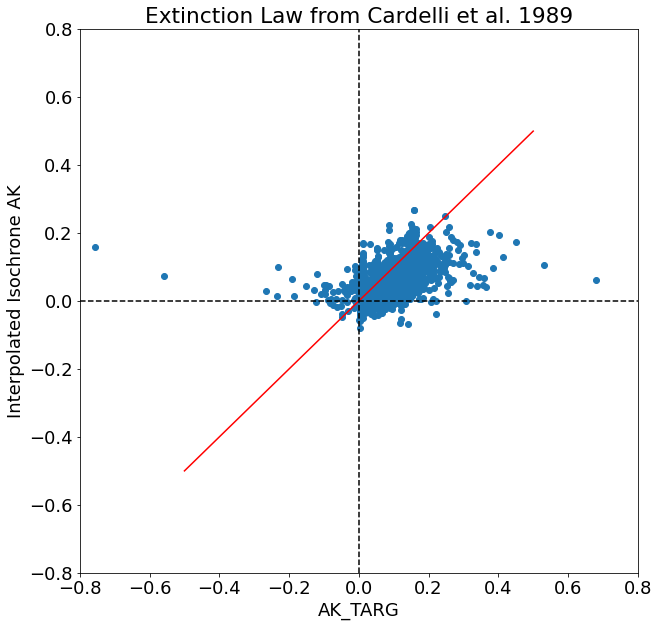

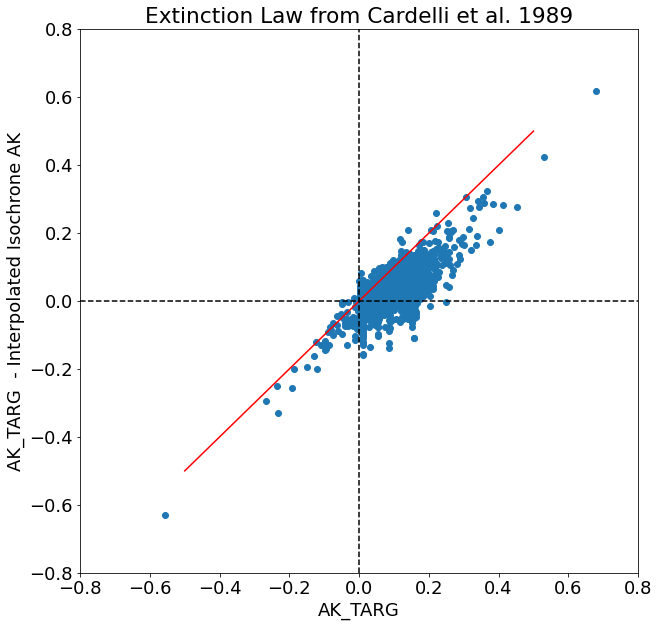

In [21]:
akejk = extinct.cardelli_alav(2.190,3.1)/extinct.cardelli_e12av(1.220,2.190,3.1)

plt.figure(figsize=[10,10])

plt.scatter(gcs['AK_TARG'],(ejk_gcs*akejk).data)
plt.plot([-0.5,0.5],[-0.5,0.5],c='r')

plt.axvline(0.0,c='k',ls='--')
plt.axhline(0.0,c='k',ls='--')

plt.xlim(-0.8,0.8)
plt.ylim(-0.8,0.8)

plt.title(r'Extinction Law from Cardelli et al. 1989')
plt.xlabel(r'AK_TARG')
plt.ylabel(r'Interpolated Isochrone AK')
plt.show()

plt.figure(figsize=[10,10])

plt.scatter(gcs['AK_TARG'],gcs['AK_TARG']-(ejk_gcs*akejk).data)
plt.plot([-0.5,0.5],[-0.5,0.5],c='r')

plt.axvline(0.0,c='k',ls='--')
plt.axhline(0.0,c='k',ls='--')

plt.xlim(-0.8,0.8)
plt.ylim(-0.8,0.8)

plt.title(r'Extinction Law from Cardelli et al. 1989')
plt.xlabel(r'AK_TARG')
plt.ylabel(r'AK_TARG  - Interpolated Isochrone AK')
plt.show()

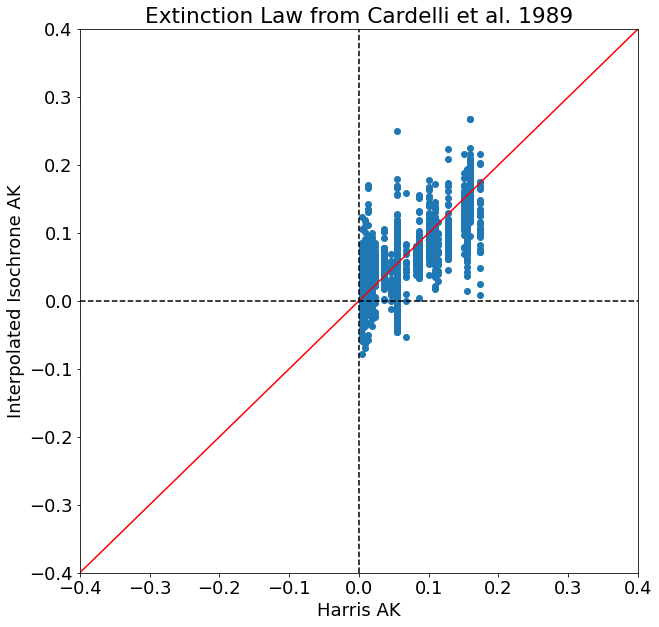

In [22]:
harris_ak = gcs['harris_ebv']*extinct.cardelli_alebv(2.190,3.1)

plt.figure(figsize=[10,10])

plt.scatter(harris_ak,(ejk_gcs*akejk).data)
plt.plot([-0.5,0.5],[-0.5,0.5],c='r')

plt.axvline(0.0,c='k',ls='--')
plt.axhline(0.0,c='k',ls='--')

plt.xlim(-0.4,0.4)
plt.ylim(-0.4,0.4)

plt.title(r'Extinction Law from Cardelli et al. 1989')
plt.xlabel(r'Harris AK')
plt.ylabel(r'Interpolated Isochrone AK')
plt.show()

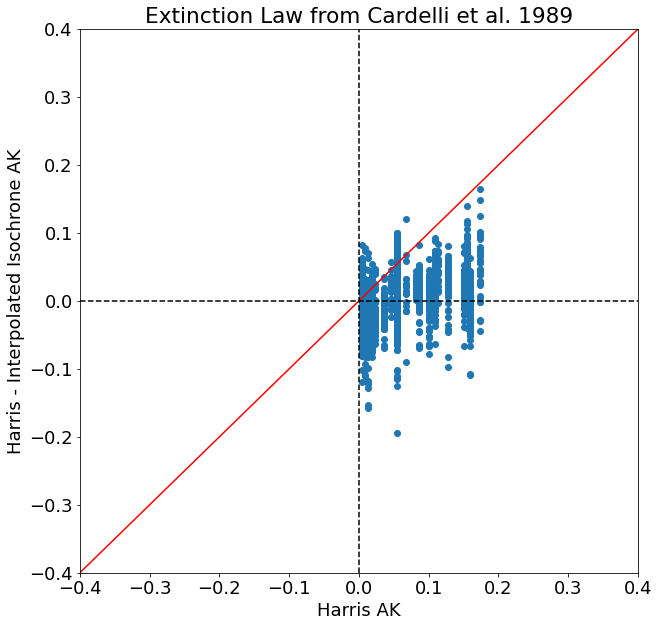

In [23]:
plt.figure(figsize=[10,10])

plt.scatter(harris_ak,harris_ak-(ejk_gcs*akejk).data)
plt.plot([-0.5,0.5],[-0.5,0.5],c='r')

plt.axvline(0.0,c='k',ls='--')
plt.axhline(0.0,c='k',ls='--')

plt.xlim(-0.4,0.4)
plt.ylim(-0.4,0.4)

plt.title(r'Extinction Law from Cardelli et al. 1989')
plt.xlabel(r'Harris AK')
plt.ylabel(r'Harris - Interpolated Isochrone AK')
plt.show()

In [24]:
jk_int_ocs = []
for i in tqdm_notebook(range(len(ocs))):
    jk_int_ocs.append(extinct.parsec_teff_2_jk(ocs_allStar['TEFF'][i],ocs_allStar['FE_H'][i],12.5,parsec12e9))

jk_int_ocs = np.asarray(jk_int_ocs)
ejk_ocs = ocs_allStar['J']-ocs_allStar['K'] - jk_int_ocs

print('negative/total: ',len(np.squeeze(np.where(ejk_ocs<0)))/len(ocs))


negative/total:  0.39644970414201186


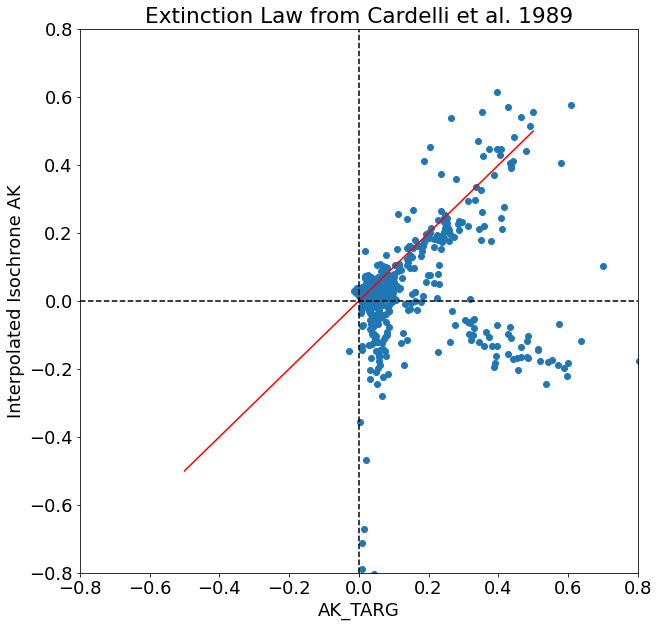

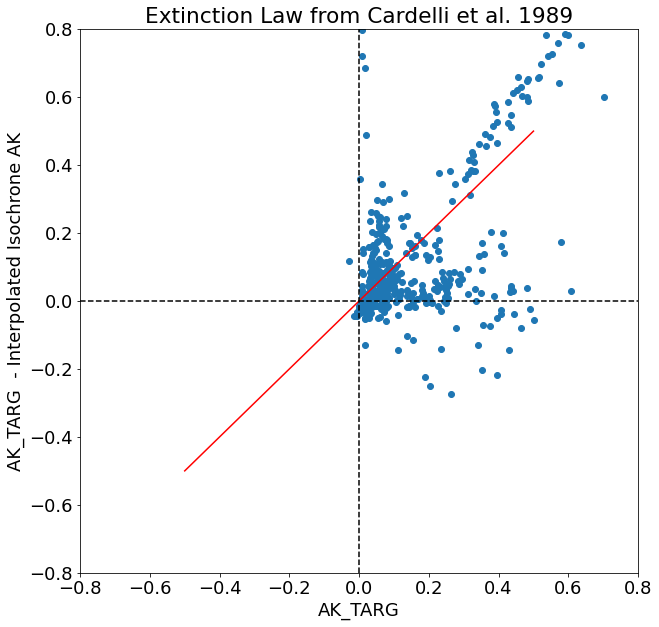

In [25]:
### Something up with OCs

akejk = extinct.cardelli_alav(2.190,3.1)/extinct.cardelli_e12av(1.220,2.190,3.1)

plt.figure(figsize=[10,10])

plt.scatter(ocs_allStar['AK_TARG'],(ejk_ocs*akejk).data)
plt.plot([-0.5,0.5],[-0.5,0.5],c='r')

plt.axvline(0.0,c='k',ls='--')
plt.axhline(0.0,c='k',ls='--')

plt.xlim(-0.8,0.8)
plt.ylim(-0.8,0.8)

plt.title(r'Extinction Law from Cardelli et al. 1989')
plt.xlabel(r'AK_TARG')
plt.ylabel(r'Interpolated Isochrone AK')
plt.show()

plt.figure(figsize=[10,10])

plt.scatter(ocs_allStar['AK_TARG'],ocs_allStar['AK_TARG']-(ejk_ocs*akejk).data)
plt.plot([-0.5,0.5],[-0.5,0.5],c='r')

plt.axvline(0.0,c='k',ls='--')
plt.axhline(0.0,c='k',ls='--')

plt.xlim(-0.8,0.8)
plt.ylim(-0.8,0.8)

plt.title(r'Extinction Law from Cardelli et al. 1989')
plt.xlabel(r'AK_TARG')
plt.ylabel(r'AK_TARG  - Interpolated Isochrone AK')
plt.show()

# CMDs with Literature Values

In [26]:
########################
### Xmatch NGC Names ###
########################

### xmatch with Wagner-Kaiser et al.

supp2 = pd.read_csv('../stx544_Supp/Table2.txt',comment='#',
                    names=['Cluster','Dist','Dist_Sigma','Av','Av_Sigma','[Fe/H]','Age'],sep='\s+')
supp2 = Table.from_pandas(supp2)

ngc_names = []
for i in range(len(gcs)):
    
    #M2: NGC7089
    if (gcs['CLUSTER'][i]=='47Tuc'): 
        ngc_names.append('NGC0104')
    
    #M10: NGC6254
    elif (gcs['CLUSTER'][i]=='M10'): 
        ngc_names.append('NGC6254')
        
    #M107: NGC6171
    elif (gcs['CLUSTER'][i]=='M107'): 
        ngc_names.append('NGC6171')
        
    #M12: NGC6218
    elif (gcs['CLUSTER'][i]=='M12'): 
        ngc_names.append('NGC6218')
        
    #M13: NGC6205
    elif (gcs['CLUSTER'][i]=='M13'): 
        ngc_names.append('NGC6205')
        
    #M19: NGC6273
    elif (gcs['CLUSTER'][i]=='M19'): 
        ngc_names.append('NGC6273')

    #M2: NGC7089
    elif (gcs['CLUSTER'][i]=='M2'): 
        ngc_names.append('NGC7089')
    
    #M22: NGC6656
    elif (gcs['CLUSTER'][i]=='M22'): 
        ngc_names.append('NGC6656')
        
    #M3: NGC5272
    elif (gcs['CLUSTER'][i]=='M3'): 
        ngc_names.append('NGC5272')
        
    #M4: NGC6121
    elif (gcs['CLUSTER'][i]=='M4'): 
        ngc_names.append('NGC6121')
        
    #M5: NGC5904
    elif (gcs['CLUSTER'][i]=='M5'): 
        ngc_names.append('NGC5904')
            
    #M53: NGC5024
    elif (gcs['CLUSTER'][i]=='M53'): 
        ngc_names.append('NGC5024')
    
    #M55: NGC6809
    elif (gcs['CLUSTER'][i]=='M55'): 
        ngc_names.append('NGC6809') 
    
    #M71: NGC6838
    elif (gcs['CLUSTER'][i]=='M71'): 
        ngc_names.append('NGC6838')
        
    #M79: NGC1904
    elif (gcs['CLUSTER'][i]=='M79'): 
        ngc_names.append('NGC1904')
        
    #NGC288: NGC0288
    elif (gcs['CLUSTER'][i]=='NGC288'): 
        ngc_names.append('NGC0288')
        
    #NGC362: NGC0362
    elif (gcs['CLUSTER'][i]=='NGC362'): 
        ngc_names.append('NGC0362')
        
    #omegaCen: NGC5139
    elif (gcs['CLUSTER'][i]=='omegaCen'): 
        ngc_names.append('NGC5139')
    
    else:
        ngc_names.append(gcs['CLUSTER'][i])
        
ngc_names = np.asarray(ngc_names)

### xmatch paper and APOGEE
_, s2_ind, _ = np.intersect1d(supp2['Cluster'], np.unique(ngc_names), return_indices=True)

supp2 = supp2[s2_ind]

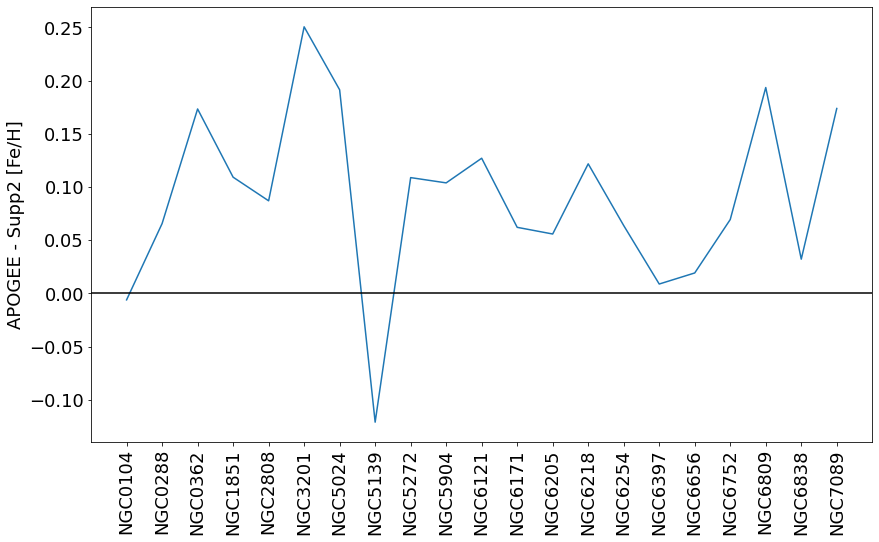

In [27]:
### Compare APOGEE [Fe/H] to Literature

gcs_feh_med = []
for i in range(len(supp2)):
    clus = np.where(ngc_names==supp2['Cluster'][i])
    gcs_feh_med.append(np.median(gcs['FE_H'][clus]))
    
plt.figure(figsize=[14,8])
plt.plot(gcs_feh_med-supp2['[Fe/H]'])
plt.axhline(0.0,c='k')
plt.xticks(np.arange(0.,len(supp2),1.),supp2['Cluster'],rotation=90)
plt.ylabel(r'APOGEE - Supp2 [Fe/H]')
plt.show()

In [28]:
### pick out columns for GC CMDs

gcs_lits_colors = []
gcs_lits_kmag = []
for i in tqdm_notebook(range(len(supp2))):
    iso = np.where((massive['logAge']==dln.closest(massive['logAge'],np.log10(supp2['Age'][i]*10**9))[0])&
                   (massive['MH']==dln.closest(massive['MH'],supp2['[Fe/H]'][i])[0]))
    
    gcs_lits_colors.append((massive['Jmag']-massive['Ksmag'])[iso])
    gcs_lits_kmag.append(massive['Ksmag'][iso])

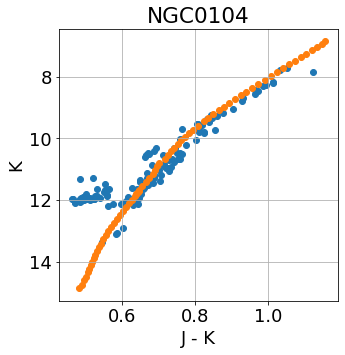

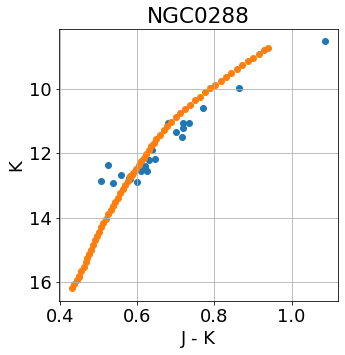

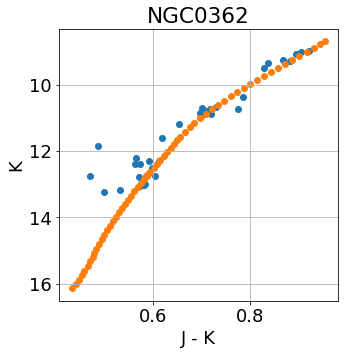

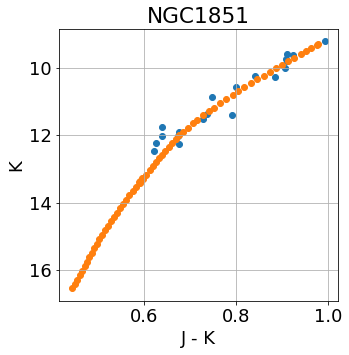

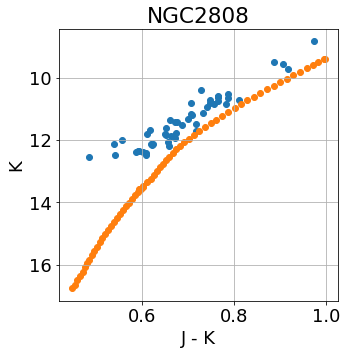

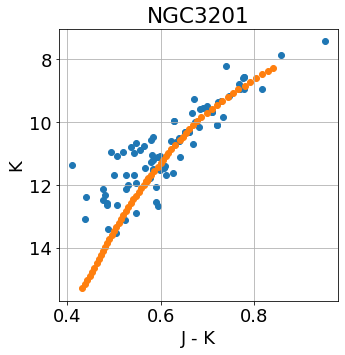

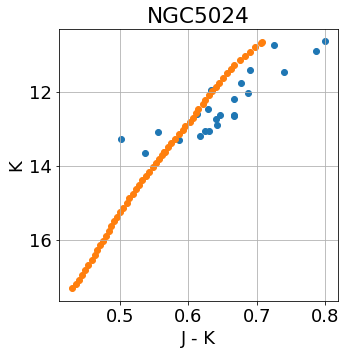

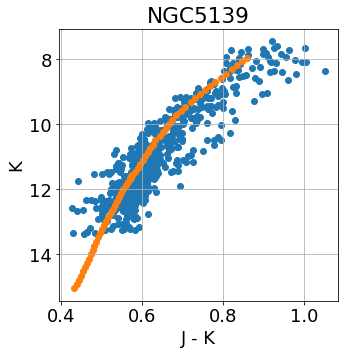

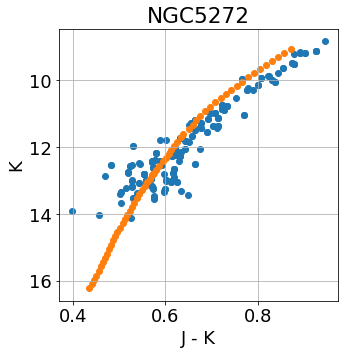

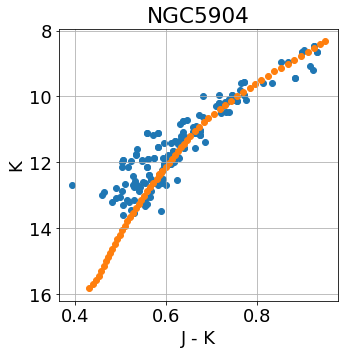

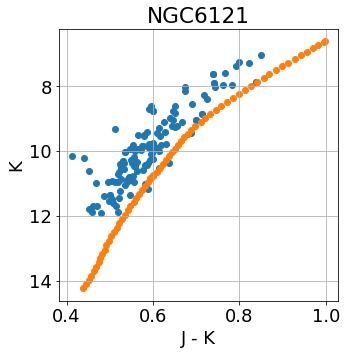

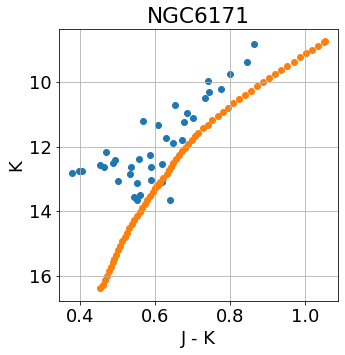

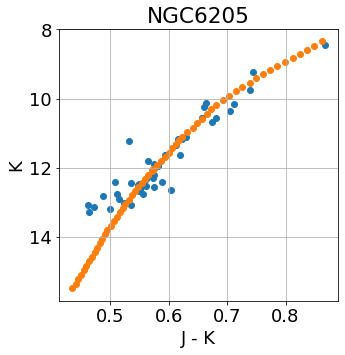

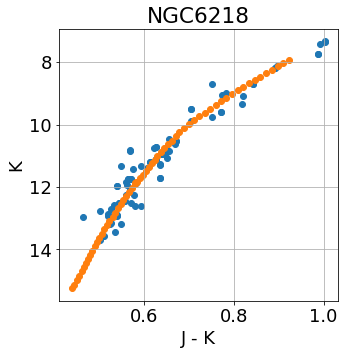

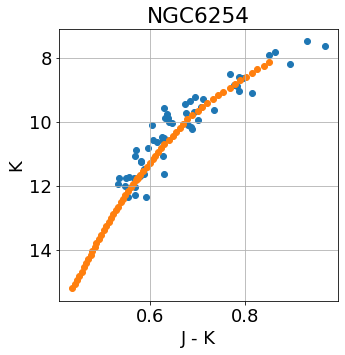

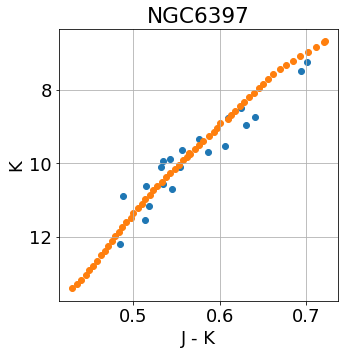

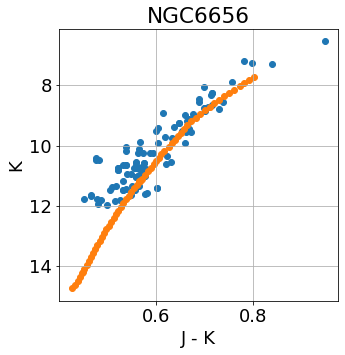

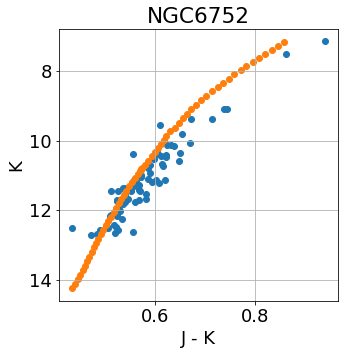

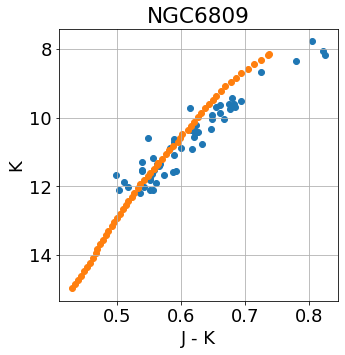

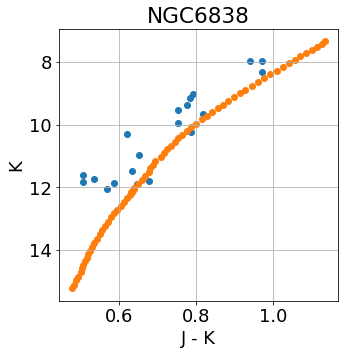

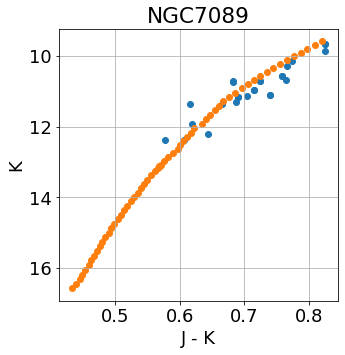

In [29]:
### CMDs for GCs

for i in range(len(gcs_lits_colors)):
    clus = np.where(ngc_names==supp2['Cluster'][i])
    
    plt.figure(figsize=[5,5])
    
    plt.scatter((gcs['J']-gcs['K'])[clus]-np.median(ejk_gcs[clus]),gcs['K'][clus]-(ejk_gcs*akejk)[clus])
    
    plt.scatter(gcs_lits_colors[i],gcs_lits_kmag[i]+supp2['Dist'][i])
    
    plt.gca().invert_yaxis()
    
    plt.grid()
    
    plt.title(supp2['Cluster'][i])
    plt.xlabel(r'J - K')
    plt.ylabel(r'K')
    plt.show()

In [70]:
len(donages)==len(np.squeeze(d1_ind))

True

In [66]:
### pick out relevant columns for OCs CMDs and HR diagrams 

ocs_lits_colors = []
ocs_lits_kmag = []
ocs_lits_teff = []
ocs_lits_logg = []
for i in tqdm_notebook(range(len(donages))):
    iso = np.where((massive['logAge']==dln.closest(massive['logAge'],np.log10(donages[i]*10**9))[0])&
                   (massive['MH']==dln.closest(massive['MH'],donfehs[i])[0]))
    
    ocs_lits_colors.append((massive['Jmag']-massive['Ksmag'])[iso])
    ocs_lits_kmag.append(massive['Ksmag'][iso])
    
    ocs_lits_teff.append(10**massive['logTe'][iso])
    ocs_lits_logg.append(massive['logg'][iso])

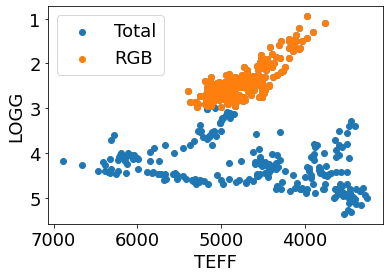

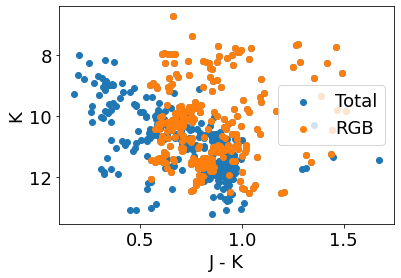

In [68]:
### Pick out RGB stars

ocs_rgb = np.where(ocs_allStar['LOGG']<3.0)

plt.scatter(ocs_allStar['TEFF'],ocs_allStar['LOGG'],label='Total')
plt.scatter(ocs_allStar['TEFF'][ocs_rgb],ocs_allStar['LOGG'][ocs_rgb],label='RGB')
plt.legend()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'TEFF')
plt.ylabel(r'LOGG')
plt.show()

plt.scatter(ocs_allStar['J']-ocs_allStar['K'],ocs_allStar['K'],label='Total')
plt.scatter((ocs_allStar['J']-ocs_allStar['K'])[ocs_rgb],ocs_allStar['K'][ocs_rgb],label='RGB')
plt.legend()
plt.gca().invert_yaxis()
plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.show()

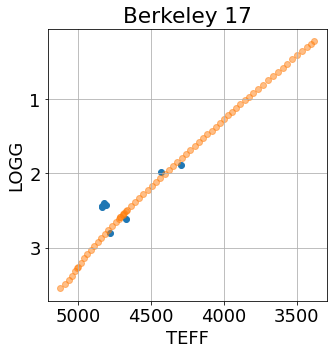

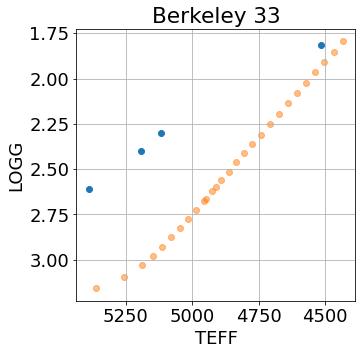

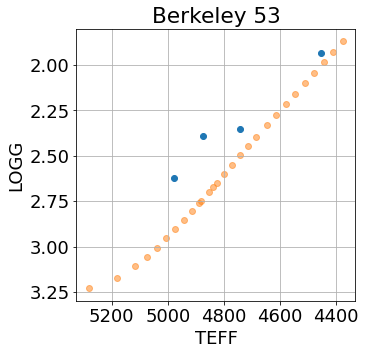

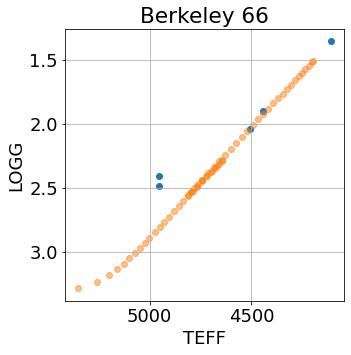

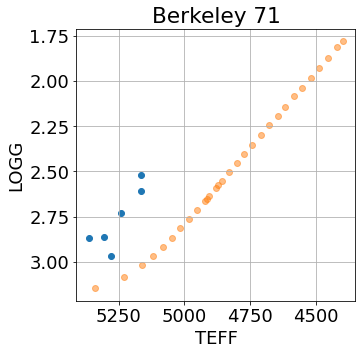

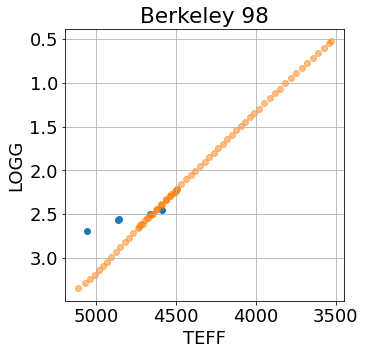

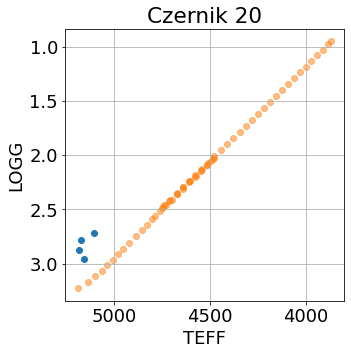

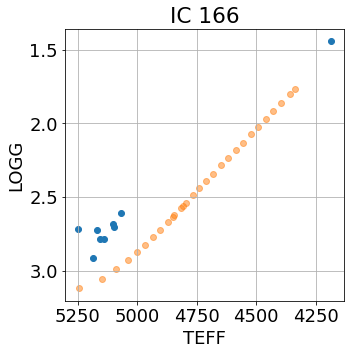

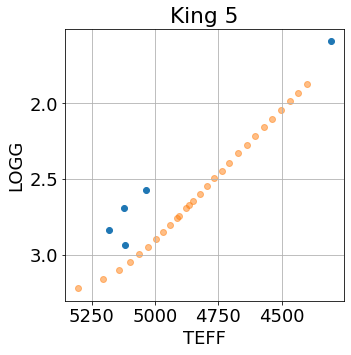

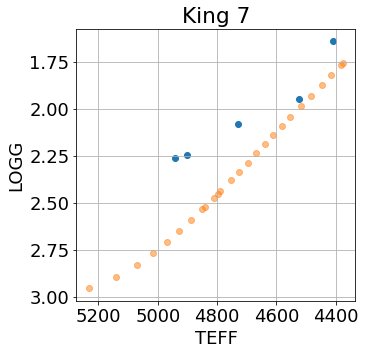

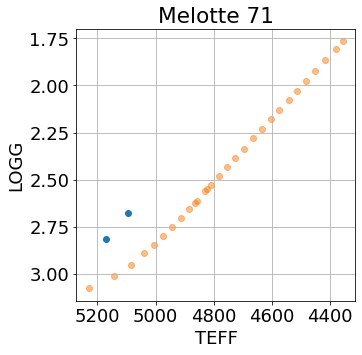

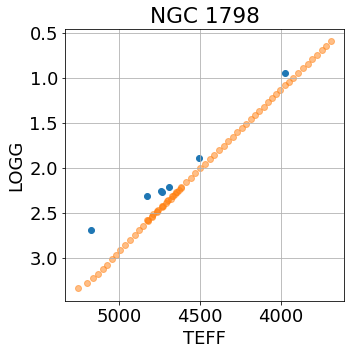

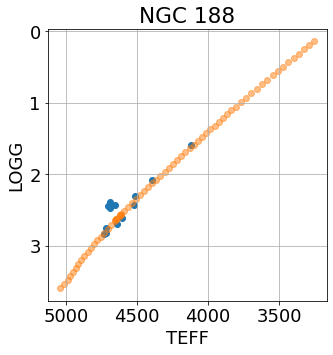

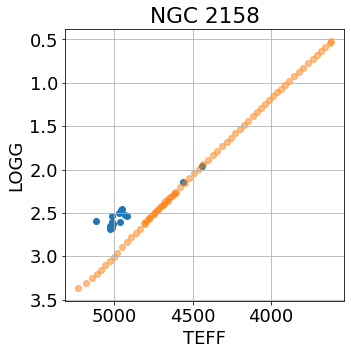

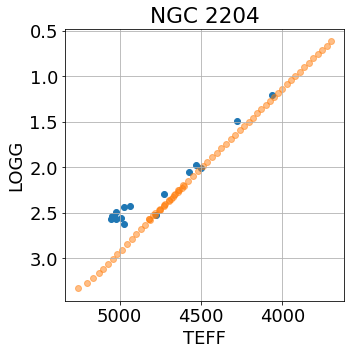

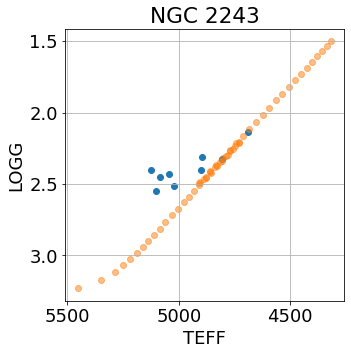

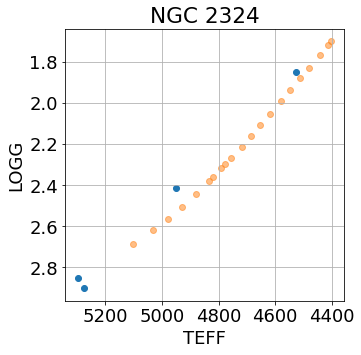

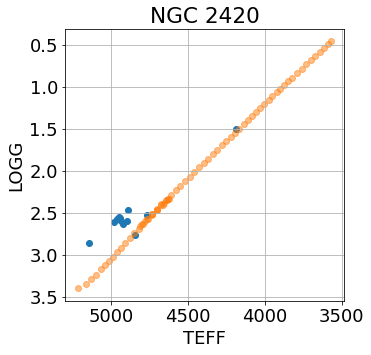

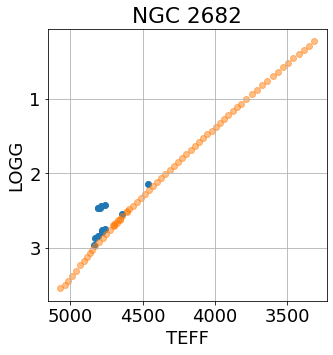

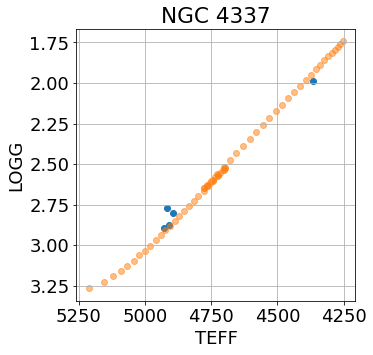

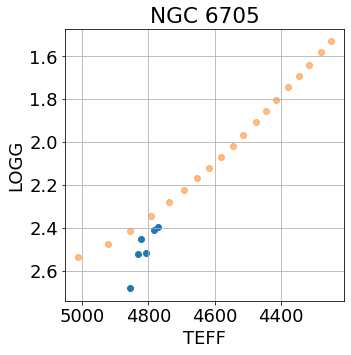

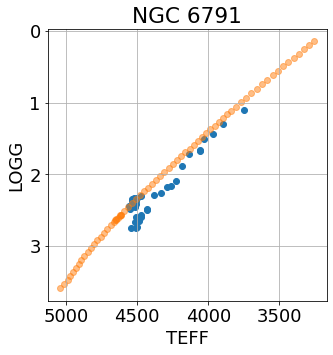

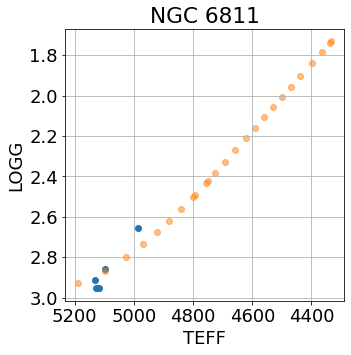

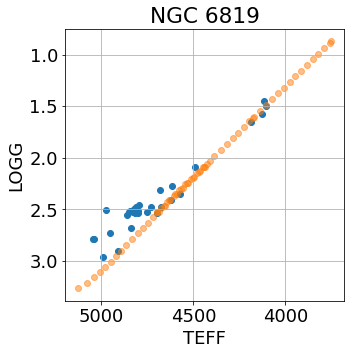

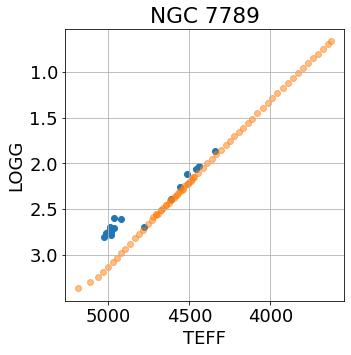

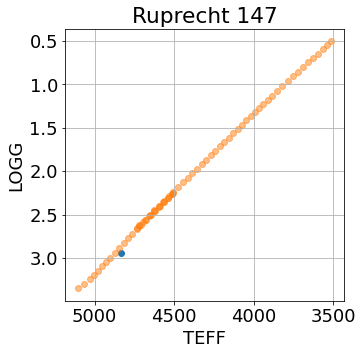

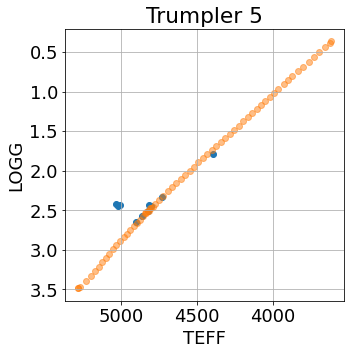

In [69]:
### HR diagrams for OCs

'''Not great, not terrible'''

for i in range(len(ocs_lits_colors)):
    clus = np.where((ocs['CLUSTER']==np.unique(ocs['CLUSTER'])[o_ind][i])&(ocs_allStar['LOGG']<3.0))
    
    if np.squeeze(clus).size!=0:
    
        plt.figure(figsize=[5,5])
    
        plt.scatter(ocs_allStar['TEFF'][clus],ocs_allStar['LOGG'][clus])
    
        plt.scatter(ocs_lits_teff[i],ocs_lits_logg[i],alpha=0.5)
    
        plt.gca().invert_yaxis()
        plt.gca().invert_xaxis()
    
        plt.grid()
    
        plt.title(np.unique(ocs['Cluster'])[o_ind][i])
        plt.xlabel(r'TEFF')
        plt.ylabel(r'LOGG')
        plt.savefig('{}_HR.pdf'.format(np.unique(ocs['Cluster'])[o_ind][i]),bbox_inches='tight')
        plt.show()

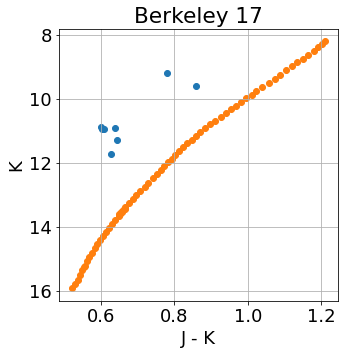

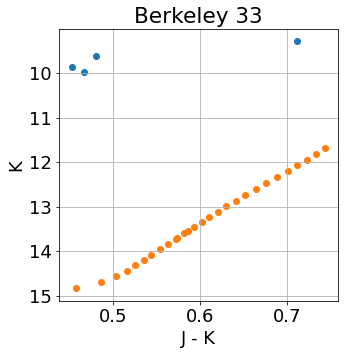

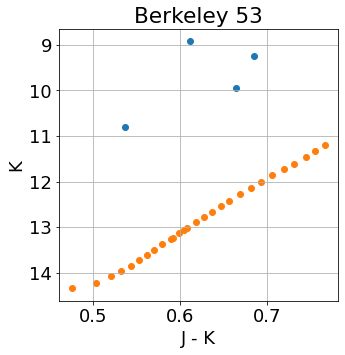

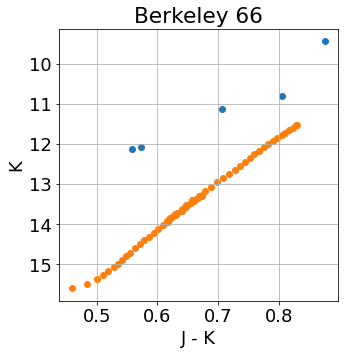

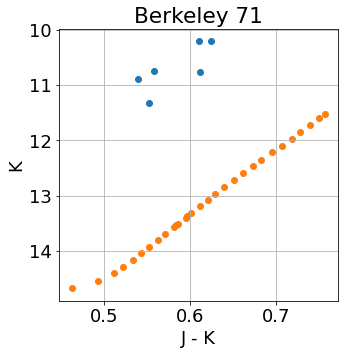

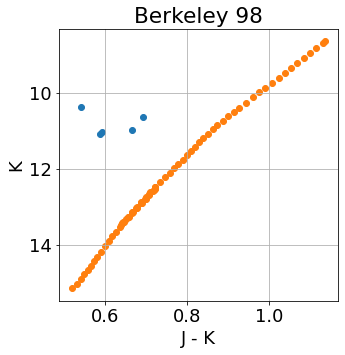

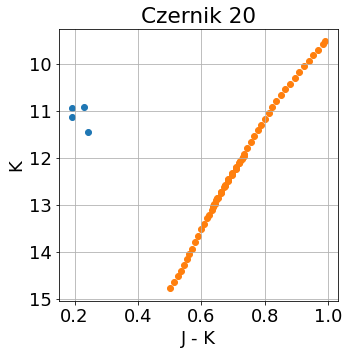

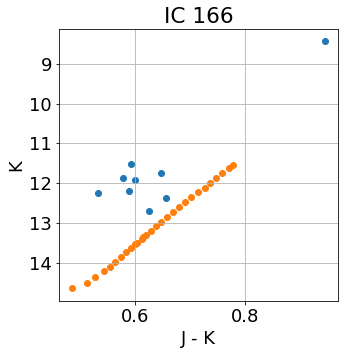

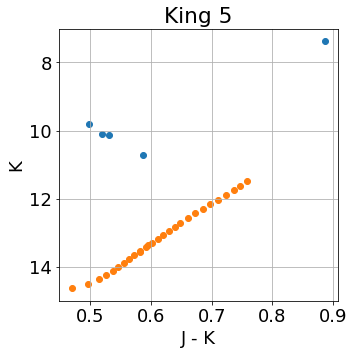

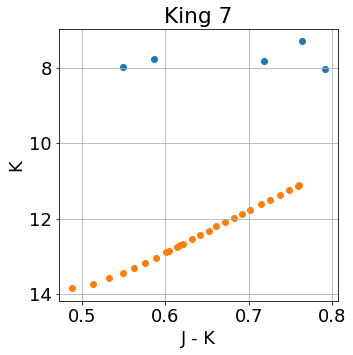

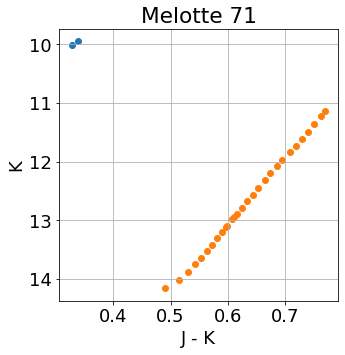

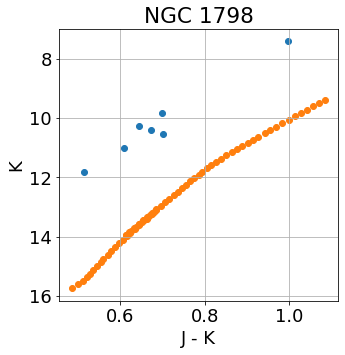

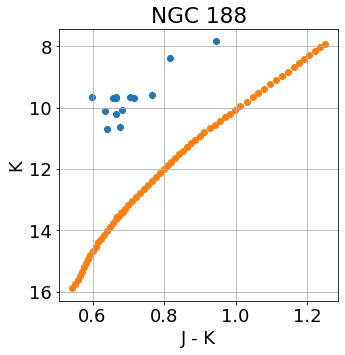

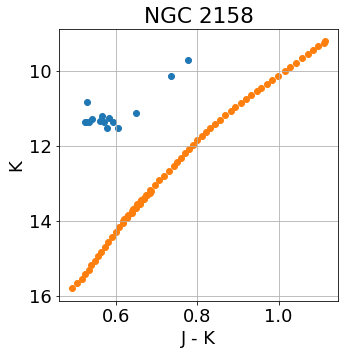

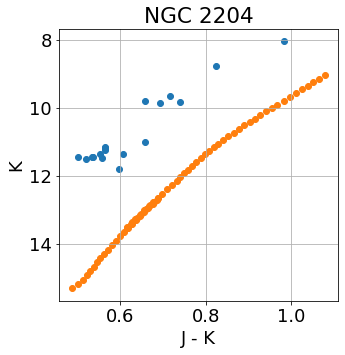

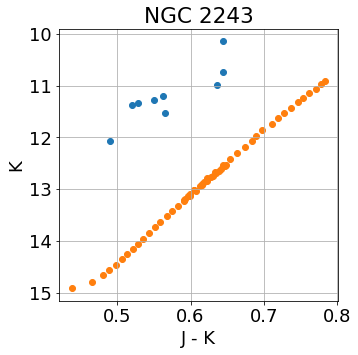

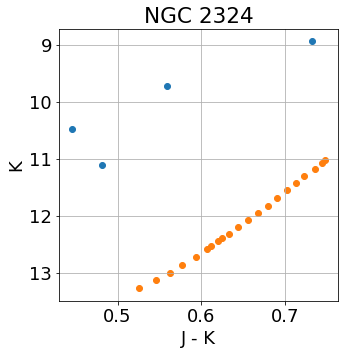

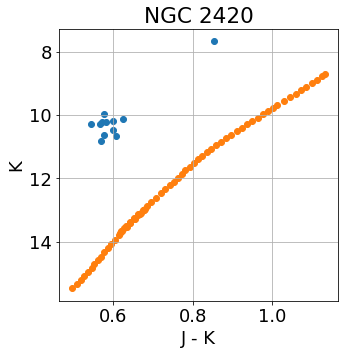

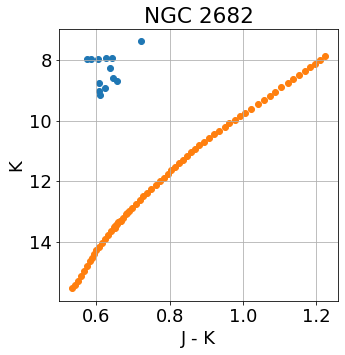

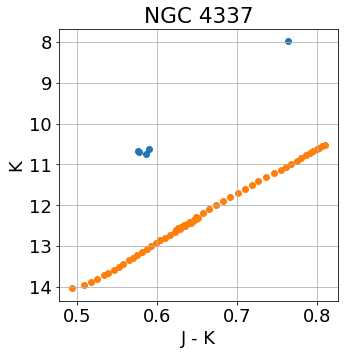

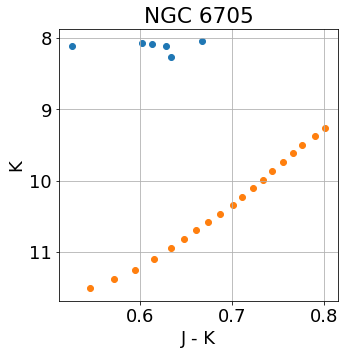

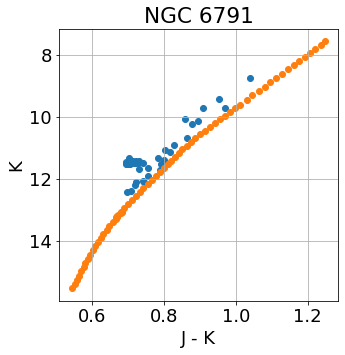

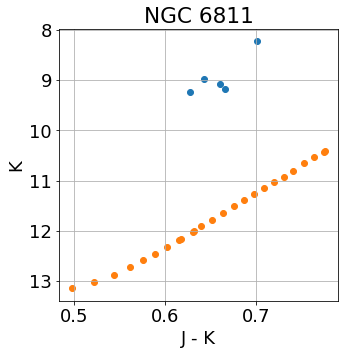

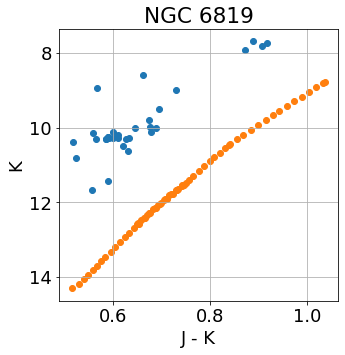

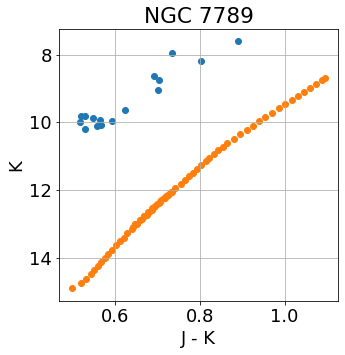

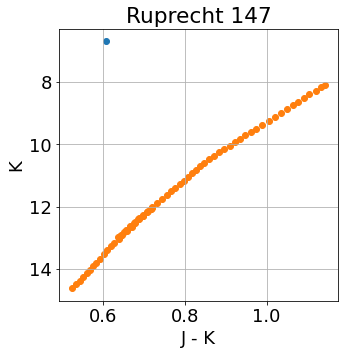

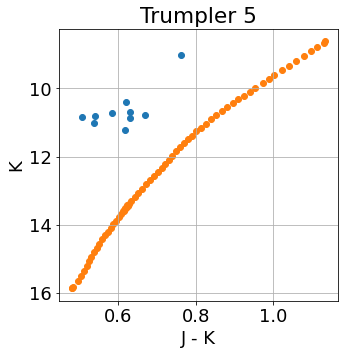

In [34]:
### still not sure what's going on with OCs

for i in range(len(ocs_lits_colors)):
    clus = np.where((ocs['CLUSTER']==np.unique(ocs['CLUSTER'])[o_ind][i])&(ocs_allStar['LOGG']<3.0))
    
    if np.squeeze(clus).size!=0:
        plt.figure(figsize=[5,5])
    
        plt.scatter((ocs_allStar['J']-ocs_allStar['K'])[clus]-np.median(ejk_ocs[clus]),
                    ocs_allStar['K'][clus]-(ejk_ocs*akejk)[clus])
        plt.scatter(ocs_lits_colors[i],ocs_lits_kmag[i]+(5.*np.log10(dondist[i])-5.))
    
        plt.gca().invert_yaxis()
    
        plt.grid()
    
        plt.title(np.unique(ocs['Cluster'])[o_ind][i])
        plt.xlabel(r'J - K')
        plt.ylabel(r'K')
        plt.savefig('{}_CMD.pdf'.format(np.unique(ocs['Cluster'])[o_ind][i]),bbox_inches='tight')
        plt.show()

In [35]:
ocs.columns

ColDefs(
    name = 'CLUSTER'; format = '13A'
    name = 'APOGEE_ID'; format = '18A'
    name = 'LOCATION_ID'; format = 'K'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'VHELIO_AVG'; format = 'D'
    name = 'VSCATTER'; format = 'D'
    name = 'FE_H'; format = 'D'
    name = 'FE_H_ERR'; format = 'D'
    name = 'PMRA'; format = 'D'
    name = 'PMRA_ERR'; format = 'D'
    name = 'PMDEC'; format = 'D'
    name = 'PMDEC_ERR'; format = 'D'
    name = 'RV_PROB'; format = 'D'
    name = 'FEH_PROB'; format = 'D'
    name = 'PM_PROB'; format = 'D'
    name = 'CG_PROB'; format = 'D'
)

In [36]:
max(donor1['Age'])

7.24

In [63]:
np.unique(ocs['CLUSTER'])[o_ind].replace(" ", "_")

chararray(['ASCC_16', 'ASCC_19', 'ASCC_20', 'ASCC_21', 'Berkeley_17',
           'Berkeley_33', 'Berkeley_53', 'Berkeley_66', 'Berkeley_71',
           'Berkeley_98', 'Chupina_3', 'Collinder_69', 'Czernik_20',
           'IC_166', 'King_5', 'King_7', 'L_1641S', 'Melotte_20',
           'Melotte_22', 'Melotte_71', 'NGC_1798', 'NGC_188', 'NGC_2158',
           'NGC_2204', 'NGC_2243', 'NGC_2264', 'NGC_2324', 'NGC_2420',
           'NGC_2682', 'NGC_4337', 'NGC_6705', 'NGC_6791', 'NGC_6811',
           'NGC_6819', 'NGC_7789', 'Ruprecht_147', 'Sigma_Orionis',
           'Trumpler_5'], dtype='<U13')

In [64]:
print(donor1['Name'].data)

['ASCC_16' 'ASCC_19' 'ASCC_20' 'ASCC_21' 'Berkeley_17' 'Berkeley_33'
 'Berkeley_53' 'Berkeley_66' 'Berkeley_71' 'Berkeley_98' 'Chupina_3'
 'Collinder_69' 'Czernik_20' 'IC_166' 'King_5' 'King_7' 'L_1641S'
 'Melotte_20' 'Melotte_22' 'Melotte_71' 'NGC_1798' 'NGC_188' 'NGC_2158'
 'NGC_2204' 'NGC_2243' 'NGC_2264' 'NGC_2324' 'NGC_2420' 'NGC_2682'
 'NGC_4337' 'NGC_6705' 'NGC_6791' 'NGC_6811' 'NGC_6819' 'NGC_7789'
 'Ruprecht_147' 'Sigma_Orionis' 'Trumpler_5']


In [74]:
donor1.show_in_browser(jsviewer=True)

In [55]:
len(d1_ind)

38